<a href="https://colab.research.google.com/github/Ele975/LLM_from_scratch/blob/main/Pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [1]:
# for tokenizer
!pip install tiktoken

# for weights loading
!pip install tensorflow>=2.15.0
!pip install tqdm>=4.66

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.0 MB/s eta 0:00:00


In [2]:
import re
import urllib.request
import tiktoken
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import pandas as pd
import torch
import time
import json
import psutil

from torch.utils.data import Dataset
from functools import partial
from pathlib import Path
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Pretraining

## Preprocessing

Download small dataset for training

In [3]:
url = ("https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt")

file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7d13f7fbffa0>)

In [4]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print('Total number of chars:', len(raw_text))
print(raw_text[:99])

Total number of chars: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


BPE tokenizer already implemented (instead of the basic ones implemented above)

In [5]:
tokenizer = tiktoken.get_encoding("gpt2")

dataset class -> each element in the dataset is a sequence of tokens, generating a dataset of successive strings. These sequences have a gap between each other of value 'stride'.

In [6]:
class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt)

    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+1+max_length]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.target_ids[idx]


Dataloader -> contains input batch and target batch because of the implementation of GPTDatasetV1 that generate the input ids and target ids

In [7]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )

  return dataloader

## Multi-head attention mechanism

Self attention class with causal mask component and dropout

In [8]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    # mask has size context_length x context_length since we need to store the attention scores and attention weights for each token before the current one (lower triangular matrix)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length, diagonal=1)))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)

    # transpose last two dimensions of keys to enable matrix multiplication -> from (batch_size, tokens_nr, embedding_dim) to (batch_size, embedding_dim, )
    attn_scores = queries @ keys.transpose(1,2)
    # access the mask above saved as buffer -> not optimized during backpropagation but available during the forward pass (often with masks)
    attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = attn_weights @ values
    return context_vec

In [9]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # create the desired number of heads using the class above that generates a single causal attention head
    self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

  def forward(self, x):
    # head(x) call the forward method of the class CausalAttention and returns the context vectors for a single head
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [10]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # the inputs are multiplied by the matrices Q,K,V generating the reduced q,v,k which have the same dimension of the output context vector.
    # For the parallel computation, q,v,k are split across the multiple heads, thus the dimension of q,v,k should be at least # heads
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.out_proj = nn.Linear(d_out, d_out)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # view = reshape from [b, num_tokens, d_in] to [b, num_tokens, self.num_heads, self.head_dim] -> dimensions of k,q,v for each head
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)

    # transpose in order to compute separately the results for each head, pass from [b, num_tokens, self.num_heads, self.head_dim] to [b, num_tokens, self.head_dim, self.num_heads]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2,3)
    # not always context_sizes correspond to num_tokens (last batch, last input can have less tokens), thus cut
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # transpose again to pass from [b, num_tokens, self.head_dim, self.num_heads] to [b, self.head_dim, num_tokens, self.num_heads]
    # permit to concanenate easier the results of the different heads
    context_vec = (attn_weights @ values).transpose(1, 2)

    # combine head results
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

    # raw concatenation is not enough for the models, thus this is used to refine the concatenation. Not mandatory but commonly used
    context_vec = self.out_proj(context_vec)
    return context_vec


## LLM model (GPT-like model)

### 1. Normalization layer
Used to avoid explosion or vanishing of the gradient through standard deviation (subtract the mean and divide by square root of variance)

In [11]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift

### 2. FNN with GELU
GELU with respect to ReLu is better for optimization.
The FNN layer permits the model to generalize and learn better the data: despite the input and output dimension is the same, internally this dimension is expanded, which permit the exporation of a richer representation space.

In [12]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [13]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)

  def forward(self, x):
    return self.layers(x)

### 3. Shortcut connections
Added between different layers to improve training performance, since they avoid gradient vanishing by skipping some layers. How? Adding inpute values to the output of certain layers. This is implemented in the next section

### 4. Transformer block
Composed by multi-head attention, layer normalization, dropout, feed forward layers, GELU activation function

In [14]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    # normalize the embedding dimension
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # save input for attention shortcut
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    # shortcut for FNN
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

### GPT architecture complete

In [15]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

Configuration parameters for GPT-like model

In [16]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,   # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

Compute total number of trainable/trained parameters

In [17]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


Generation of possibly multiple tokens, whose length depends on the user.Multiple iteration of the generation of a next token permit the model to generate meaninful complete sentences.

Simple version without text originality


In [18]:
# idx -> input with size (batch, token ids)
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # crops current context size to supported context size by the model -> if model supports size 5 and context size is 10, maintain last 5 tokens as context
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    # output of model is (batch, token, vocab), thus take last token
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    # get idx of the next token that will be part of the next input given to the model
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx


Complete version with text originality (answers vary depending on the value of temperature and thanks to the usage of multinomial)

In [19]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:, -1, :]
    # choose if possible top k tokens
    if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      # set all other logits to -inf
      logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device),logits)

    if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
    else:
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

    if idx_next == eos_id:
      break

    idx = torch.cat((idx, idx_next), dim=1)
  return idx

Configuration for the model

In [20]:
# shorter context_length
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Functions to convert from tokens to tokens IDs and opposite (the model outputs are token IDs)

In [21]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  # insert batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  # remove batch dimension
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

### Dataset preparation and loss functions

Load small dataset 'The verdict'

In [22]:
file_path = "the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as f:
  text_data = f.read()

get text length

In [23]:
total_chars = len(text_data)
total_tok = tokenizer.encode(text_data)
print("Total characters:", total_chars)
print("Total tokens:", len(total_tok))

Total characters: 20479
Total tokens: 5145


Split dataset into training set and validation set with ratio of 90% and 10%

In [24]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Data loader -> divided per batch and contains batch with inputs and outputs

In [25]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = shuffle,
      drop_last = drop_last,
      num_workers = num_workers
  )

  return dataloader

In [26]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [27]:
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Compute loss function for a single batch

In [28]:
def calc_loss_batch(input_batch, target_batch, model, device):
  # transferring data to a device permit to transfer data to GPU
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  # logits.flatten(0,1) -> merge dimensions 0 and 1 into a single one, from (batch_dim, nr_tokens, vocab_dim) to (batch_dim*nr_tokens, vocab_dim)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
  return loss


Compute loss for all batches of traning and validation set

In [29]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  # if num_batches not specified
  elif num_batches is None:
    # dataloader returns data grouped by batches
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      # sum loss over batches
      total_loss += loss.item()
    else:
      break
  # average loss over all batches
  return total_loss/num_batches


Compute loss (the result is high since no training has been performed yet)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device)
  val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


### Training loop

training:
1. iterate over each epoch (complete iteration over all input data)
2. iterate over each batch
3. reset loss gradients for each batch (batches are processed independently and their loss shouldn't be summed up).
4. compute loss on current batch (forward pass)
5. compute backpropagation (backward pass) to compute gradient of the loss with respect to the parameters (weights, biases)
6. update parameters based on the gradients get in the previous step
7. (print training and validation losses for tracking progress)

Evaluating the validation set within the training process permit to understand how the model perform on unseen data in order to use techniques to improve precision if needed (modify hyperparameter such as batch size, learning rate, etc. ) and can implement strategies such as early stopping to avoid a biased model on training data (overfitting). In addition spikes in validation data indicates issues in the training process

In [31]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
  # track losses and tokens seen
  train_losses, val_losses, track_tokens_seen = [], [], []
  # global_step initialized with -1 so that it can work as index
  tokens_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      # compute loss gradients
      loss.backward()
      # update model parameters depending on loss gradients
      optimizer.step()
      tokens_seen += input_batch.numel()
      global_step += 1

      # eval_freq is the frequency on which we evaluate the model on a validation or test set (if 5, each 5 batches we evaluate the model), optional to see improvements
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)

        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {val_loss:.3f}"
              )

    generate_and_print_sample(model, tokenizer, device, start_context)
  return train_losses, val_losses, track_tokens_seen




Evaluation: compute loss over training and evaluation sets ensuring model is in evaluation mode without dropout  

In [32]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  # not required in evaluation and save computational space
  with torch.no_grad():
    # compute loss for multiple batches to have more stable evaluation
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    # swap again to training mode for the training process in train_model_simple()
    model.train()
    return train_loss, val_loss

Evaluate the model by taking a text snippet and passing to the model

In [33]:
# start_context = text snippet for evaluation purposes
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  # in the positional embedding weights the first shape is the context size
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    # use the model in order to get the predicted next tokens starting from start_context
    token_ids = generate_text_simple(model=model, idx=encoded,max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

Train the model -> the result is not precise because of the limited size of the dataset

In [34]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
     model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer,
    device,num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer)

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

Plot training and validation loss -> the model overfit due to the small dataset and the absence of techniques to improve it, but this is a very basic training only for demonstration purposes

In [35]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2 = ax1.twiny()
  ax2.plot(tokens_seen, train_losses, alpha=0)
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

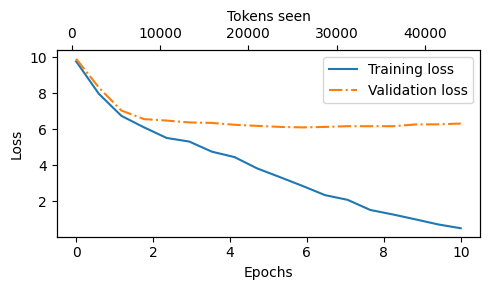

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Save the model in order to not execute the training everytime (computational advantage) such that even if the session is closed the model will be still available. Two options:
1. save the model only -> if we don't perform any additional training (only inference)
2. save the model and the optimizer -> if additional training is performed, the optimizer contains important parameters that are needed in order to have a correct convergence

In [37]:
# # save onyl the model
torch.save(model.state_dict(), "model.pth")

# # save the model and the optimizer
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
#     },
#     "model_and_optimizer.pth"
# )

Load model (in general this is done in another notebook in order to not run the training again)

In [38]:
checkpoint = torch.load("model.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))

# checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# # if we save also the optimizer, this means we want to train it again thus set train state
# model.train();

<ipython-input-38-009bcedfee57>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model.pth", map_location=device)
<ipython-input-38-009bcedfee57>:3:

<All keys matched successfully>

## Pretrained weights loading

Since if the device is computationally limited the training is not effective, it is possible to load the weights of the GPT-2 models obtained during pretraining.

In [39]:
# get gpt_download.py

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7d133c1dc610>)

Load GPT-2 architecture settings and parameters

In [40]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 116kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.07MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 32.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:19<00:00, 25.8MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.12MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.34MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.12MiB/s]


In [41]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


All configurations for GPT-2 models (small, medium, large, xl)

In [42]:
model_configs = {
  "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
  "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
  "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
  "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

Update our previous config ('GPT_CONFIG_124M') with new parameters

In [43]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({"context_length": 1024})
# not used anymore but need to match the settings employed
NEW_CONFIG.update({"qkv_bias": True})

create new GPT instance with new parameters, however the initial weights are random

In [44]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Function to check that left and right tensors have same shape (check if assignment of data is correct)

In [45]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

Assign loaded parameters to the new model with the new configuration. Complex function and based on some guessing since GPT used different names. It is possible to load the pretrained GPT model without manually assign all parameters, but this is for demonstration purpose (i.e. model = GPT2Model.from_pretrained("gpt2"))

In [46]:
def load_weights_into_gpt(gpt, params):
  # assign positional and token embeddings
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  # iteration over all transformer blocks
  for b in range(len(params["blocks"])):
    # query, key and value components for self attention mechanism
    # split concatenated weights for q,k,v into 3 components q_w, k_w, v_w, transpose and assign
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(
        gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(
        gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(
        gpt.trf_blocks[b].att.W_value.weight, v_w.T)

    # same for biases
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(
        gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(
        gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(
        gpt.trf_blocks[b].att.W_value.bias, v_b)

    # output projection
    gpt.trf_blocks[b].att.out_proj.weight = assign(
        gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

    # feedforward nn
    gpt.trf_blocks[b].ff.layers[0].weight = assign(
        gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
        gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(
        gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
        gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

    # layer normalization, where scale='g' for gain and shift='b' for bias
    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

  # final layer normalization and output head
  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [47]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Use model with loaded parameters to see token prediction and check that output text is coherent.

In [48]:
torch.manual_seed(123)
token_ids = generate(
model=gpt,
idx=text_to_token_ids("Every effort moves you", tokenizer).to(device), max_new_tokens=25,
context_size=NEW_CONFIG["context_length"],
top_k=50,
temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
